In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from project.ranker.ranker import RankingPredictor
from project.ranker.ranker import RandomRankingPredictor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Lectura de datasets
from project.utils import read_datasets
datasets = read_datasets("ma")

In [4]:
# baseline predictors

In [5]:
rp = Pipeline([
    ('scale', StandardScaler()),
    ('estimator', RankingPredictor("ma_100", n_neighbors=5)),
])

In [6]:
rrp = RandomRankingPredictor()

In [7]:
# Meta data

In [8]:
mf, fs = rp.named_steps['estimator']._get_data()

In [243]:
X = mf.toDataFrame()

In [244]:
X.head()

,X_correlation_max,X_correlation_mean,X_correlation_min,X_covariance_max,X_covariance_mean,X_covariance_min,X_exp_var_max,X_exp_var_n_t80_cumsum,X_kurtosis_max,X_kurtosis_mean,...,X_stand_dev_min,X_std_covariance_max,X_std_covariance_mean,X_std_covariance_min,X_std_exp_var_max,X_var_coef_max,X_var_coef_mean,X_var_coef_min,y_norm_class_entropy_none,y_num_classes_none
dataset,,,,,,,,,,,,,,,,,,,,,
dataset_prostate_singh,0.994905,0.001368,-0.989840,6.501921e+06,29.654376,-1.662059e+06,0.538233,3,96.809515,3.634957,...,45.069954,0.994905,0.001368,-0.989840,0.635789,24.644940,0.968532,0.393882,0.999723,2
dataset_glioma_phillips,0.993589,0.026853,-0.690733,4.323435e+08,245013.502247,-6.592495e+07,0.311808,16,94.998000,6.624304,...,849.046524,0.993589,0.026853,-0.690733,0.144017,6.143025,0.497883,0.196919,0.795040,2
dataset_leukemia_armstrong,0.994280,0.084879,-0.916524,1.154806e+08,556524.637475,-7.348629e+07,0.249095,19,64.783987,3.472936,...,1480.763026,0.994280,0.084879,-0.916524,0.241996,2.250262,0.511498,0.239257,0.991532,3
dataset_breast_sotiriou,0.997310,0.703431,-0.803858,6.244864e+00,1.451080,-5.063628e+00,0.721969,3,10.362369,-0.156562,...,1.308462,0.997310,0.703431,-0.803858,0.745195,0.389483,0.202296,0.182322,0.993717,3
dataset_lymphoma_dave_2,0.985847,0.019387,-0.739594,5.893252e+00,0.027503,-3.396945e+00,0.124228,93,35.139636,1.273938,...,0.610939,0.985847,0.019387,-0.739594,0.140919,0.525447,0.158073,0.086560,0.882052,4


In [425]:
y, ys = fs.ranking("max", return_scores=True)

In [246]:
y.mean().sort_values()

minmax_random_forest_linearSVC     5.683333
minmax_fisher_linearSVC            5.950000
minmax_chi_square_linearSVC        6.333333
minmax_fisher_naiveBayes           6.483333
minmax_random_forest_naiveBayes    6.600000
minmax_chi_square_logReg           7.150000
minmax_chi_square_naiveBayes       7.200000
minmax_random_forest_logReg        7.233333
minmax_reliefF_linearSVC           7.366667
minmax_rfe_svc_linearSVC           7.550000
minmax_reliefF_naiveBayes          7.700000
minmax_reliefF_logReg              7.833333
minmax_fisher_logReg               7.916667
dtype: float64

In [247]:
X = X.values
y = y.values
ys = ys.values

In [248]:
# Train test split 

In [251]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, y_scores_train, y_scores_test = train_test_split(X, y, ys)

In [252]:
# Random Ranker metric evaluation

In [275]:
y_pred = rrp.fit(X_train, y_train).predict(X_test)

In [276]:
from project.utils.metrics import evaluate_metric

In [277]:
evaluate_metric("spearman", y_test, y_pred)

-0.019047619047619035

In [278]:
evaluate_metric("mean_acc_loss", y_scores_test, y_pred)

0.12097950765050244

In [257]:
# KNN Ranker metric evaluation

In [261]:
y_pred = rp.fit(X_train, y_train).predict(X_test)

In [262]:
evaluate_metric("spearman", y_test, y_pred)

0.0750915750915751

In [263]:
evaluate_metric("mean_acc_loss", y_scores_test, y_pred)

0.1437576456065914

In [36]:
# metricas en validación cruzada

In [279]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

In [330]:
cv = KFold(n_splits=5, shuffle=True)

In [331]:
spearman = []
acc_loss = []
for i in range(100):
    y_pred = cross_val_predict(rrp, X, y, cv=cv)
    spearman.append(evaluate_metric("spearman", y, y_pred))
    acc_loss.append(evaluate_metric("mean_acc_loss", ys, y_pred))

In [332]:
print("Spearman: ")
print("mean: ", np.mean(spearman))      
print("std: ", np.std(spearman))

Spearman: 
mean:  0.0022930402930402935
std:  0.03776097967248271


In [333]:
print("Acc Loss: ")
print("mean: ", np.mean(acc_loss))      
print("std: ", np.std(acc_loss))

Acc Loss: 
mean:  0.1395021753704942
std:  0.016898490180910945


In [334]:
rp = Pipeline([
    ('scale', StandardScaler()),
    ('estimator', RankingPredictor("ma_100", n_neighbors=5)),
])

In [335]:
spearman = []
acc_loss = []
for i in range(100):
    y_pred = cross_val_predict(rp, X, y, cv=cv)
    spearman.append(evaluate_metric("spearman", y, y_pred))
    acc_loss.append(evaluate_metric("mean_acc_loss", ys, y_pred))

In [336]:
print("Spearman: ")
print("mean: ", np.mean(spearman))      
print("std: ", np.std(spearman))

print("Acc Loss: ")
print("mean: ", np.mean(acc_loss))      
print("std: ", np.std(acc_loss))

Spearman: 
mean:  0.026293956043956034
std:  0.03408753021537794
Acc Loss: 
mean:  0.15483204881811952
std:  0.014031918857795743


In [337]:
# Feature selection

In [338]:
from sklearn.feature_selection import VarianceThreshold

In [342]:
rp = Pipeline([
    ('scale', MinMaxScaler()),
    ('fs', VarianceThreshold(0.05)),
    ('estimator', RankingPredictor("ma_100", n_neighbors=5)),
])

In [343]:
spearman = []
acc_loss = []
for i in range(100):
    y_pred = cross_val_predict(rp, X, y, cv=cv)
    spearman.append(evaluate_metric("spearman", y, y_pred))
    acc_loss.append(evaluate_metric("mean_acc_loss", ys, y_pred))

In [344]:
print("Spearman: ")
print("mean: ", np.mean(spearman))      
print("std: ", np.std(spearman))
print()

print("Acc Loss: ")
print("mean: ", np.mean(acc_loss))      
print("std: ", np.std(acc_loss))

Spearman: 
mean:  0.05876739926739926
std:  0.03826208667551665

Acc Loss: 
mean:  0.15344102544252428
std:  0.01514804158519196


In [352]:
def evaluate(pipeline, X, y, ys, print_values=False):
    spearman = []
    acc_loss = []
    for i in range(100):
        y_pred = cross_val_predict(pipeline, X, y, cv=cv)
        spearman.append(evaluate_metric("spearman", y, y_pred))
        acc_loss.append(evaluate_metric("mean_acc_loss", ys, y_pred))
    
    
    if print_values:
        print("Spearman: ")
        print("mean: ", np.mean(spearman))      
        print("std: ", np.std(spearman))
        print()

        print("Acc Loss: ")
        print("mean: ", np.mean(acc_loss))      
        print("std: ", np.std(acc_loss))
    
    return np.mean(spearman), np.mean(acc_loss)

In [353]:
all_spearman = []
all_acc_loss = []
for k in range(1,41):    
    rp = Pipeline([
        ('scale', StandardScaler()),
        ('fs', VarianceThreshold(0.05)),
        ('estimator', RankingPredictor("ma_100", n_neighbors=k)),
    ])
    
    print("K: ", k)
    s, a  = evaluate(rp, X, y, ys, print_values = True)
    all_spearman.append(s)
    all_acc_loss.append(a)
    print("------")

K:  1
Spearman: 
mean:  0.04598168498168498
std:  0.03579455448558565

Acc Loss: 
mean:  0.16929260727434872
std:  0.010783346268642661
------
K:  2
Spearman: 
mean:  0.04130860805860805
std:  0.0345952227632305

Acc Loss: 
mean:  0.16881140558233906
std:  0.014933715014906049
------
K:  3
Spearman: 
mean:  0.03608241758241758
std:  0.026379558945594545

Acc Loss: 
mean:  0.16287966180962937
std:  0.012198867852519679
------
K:  4
Spearman: 
mean:  0.02572985347985348
std:  0.036420233538346086

Acc Loss: 
mean:  0.16002523403418356
std:  0.015757595529060506
------
K:  5
Spearman: 
mean:  0.027885531135531133
std:  0.033084283493328516

Acc Loss: 
mean:  0.15521396121645087
std:  0.013449213821261642
------
K:  6
Spearman: 
mean:  0.012502747252747254
std:  0.03323884550907579

Acc Loss: 
mean:  0.16043975629761473
std:  0.013387268964286821
------
K:  7
Spearman: 
mean:  0.034083333333333334
std:  0.02991999908110544

Acc Loss: 
mean:  0.15512227146194382
std:  0.013447069492423441
-

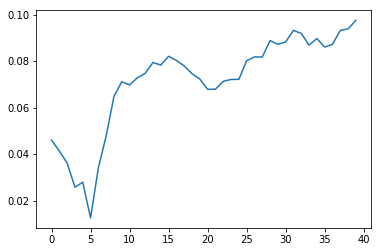

In [354]:
plt.plot(all_spearman)

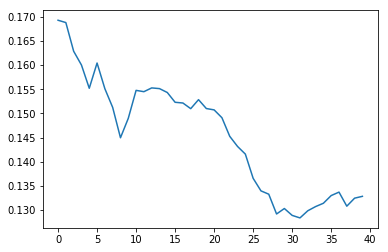

In [355]:
plt.plot(all_acc_loss)

In [420]:
all_spearman = []
all_acc_loss = []
for k in range(1,41):    
    rp = Pipeline([
        ('fs', VarianceThreshold(0.05)),
        ('scale', StandardScaler()),        
        ('estimator', RankingPredictor("ma_100", n_neighbors=k)),
    ])
    
    print("K: ", k)
    s, a  = evaluate(rp, X, y, ys, print_values = True)
    all_spearman.append(s)
    all_acc_loss.append(a)
    print("------")

K:  1
Spearman: 
mean:  0.01811904761904761
std:  0.03181770467139154

Acc Loss: 
mean:  0.15937065712325477
std:  0.01305010092367943
------
K:  2
Spearman: 
mean:  0.02503388278388278
std:  0.0326428907327047

Acc Loss: 
mean:  0.1579930861572917
std:  0.013109705908101166
------
K:  3
Spearman: 
mean:  0.014841575091575085
std:  0.036752611432310754

Acc Loss: 
mean:  0.15902049235267168
std:  0.015666236513603177
------
K:  4
Spearman: 
mean:  0.010689560439560437
std:  0.029492175466355082

Acc Loss: 
mean:  0.15748221623045494
std:  0.014671634246244042
------
K:  5
Spearman: 
mean:  0.006634615384615381
std:  0.0357917057332877

Acc Loss: 
mean:  0.15552532278118453
std:  0.013489301661873666
------
K:  6
Spearman: 
mean:  0.012065018315018317
std:  0.03178886919577046

Acc Loss: 
mean:  0.1539547279395336
std:  0.012861447808842717
------
K:  7
Spearman: 
mean:  0.012126373626373626
std:  0.03251813367282373

Acc Loss: 
mean:  0.15549761988657498
std:  0.015210173897485484
----

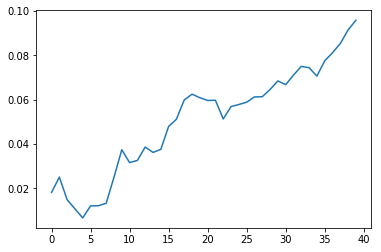

In [421]:
plt.plot(all_spearman)

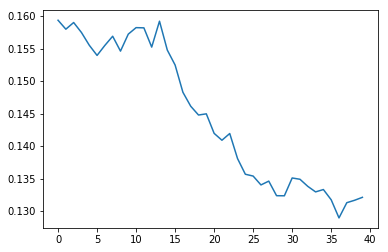

In [422]:
plt.plot(all_acc_loss)

In [417]:
foo = Pipeline([
    ('fs', VarianceThreshold(0.05)),
    ('scale', StandardScaler()),
])

In [418]:
bar = foo.fit_transform(X)

In [302]:
rp = Pipeline([
    ('scale', StandardScaler()),
    ('fs', VarianceThreshold(0.06)),
    ('estimator', RankingPredictor("ma_100", n_neighbors=5)),
])

In [303]:
spearman = []
acc_loss = []
for i in range(100):
    y_pred = cross_val_predict(rp, X, y, cv=cv)
    spearman.append(evaluate_metric("spearman", y, y_pred))
    acc_loss.append(evaluate_metric("mean_acc_loss", y, y_pred))

In [304]:
print("Spearman: ")
print("mean: ", np.mean(spearman))      
print("std: ", np.std(spearman))
print()

print("Acc Loss: ")
print("mean: ", np.mean(acc_loss))      
print("std: ", np.std(acc_loss))

Spearman: 
mean:  0.022371794871794862
std:  0.03559552551782791

Acc Loss: 
mean:  17.68408333333333
std:  1.2422935190606124
